In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
# from backtest import executer
import matplotlib.pyplot as plt
import plotly.express as px
import math
import ast

In [2]:
# MAKE BACKTEST

# dfs = executer(n_workers=6)

# df_list = [pd.DataFrame(d) for d in dfs]
# df = pd.concat(df_list)
# df.head()

In [3]:
portfolio = pd.read_excel('PORTFOLIO.xlsx')

df = pd.read_csv('backtest_result_corrigido.csv')
df['date'] = pd.to_datetime(df.date)

df['stock1'] = [pair.split("'")[1] for pair in df.pair]

In [4]:
df = df.merge(portfolio.drop_duplicates('ticker'), left_on='stock1', right_on='ticker',how='left')

In [5]:
df.drop(columns=['stock1', 'ticker'], inplace=True)

In [69]:
df.price_fst_stock.mean()

22.521670217337917

In [36]:
def result_calculator(row):
    
    long_result = row['price_fst_stock'] - row['open_price_first_stock']
    short_result = row['open_price_scnd_stock'] - row['price_scnd_stock']

    result = long_result + short_result
    
    if row['residual_open'] > row['std_open_residual']:
        result = - result

    return result 

In [37]:
cond = (df.status.isin(['True', 'close']))

In [38]:
df.loc[cond, 'result'] = df.loc[cond].apply(lambda row: result_calculator(row), axis=1)

In [68]:
df.loc[(df.status=='True') & (df.date=='2022-06-09')].result_beta_neutral.sum()

4.290283241735996

In [39]:
# Cash Neutral

# quant1 = df.loc[cond, 'open_price_first_stock'] / (df.loc[cond, 'open_price_scnd_stock'] + df.loc[cond, 'open_price_first_stock'])
# quant2 = 1-quant1

quant2 = df.loc[cond].open_price_first_stock / df.loc[cond].open_price_scnd_stock
quant1 = 1

df.loc[cond,'quant1'] = quant1
df.loc[cond,'quant2'] = quant2

result = (quant1) * (df.loc[cond, 'price_fst_stock'] - df.loc[cond, 'open_price_first_stock']) + (df.loc[cond, 'open_price_scnd_stock'] - df.loc[cond,'price_scnd_stock']) * (quant2)

df.loc[cond,'cash'] = (quant1 * df.loc[cond, 'open_price_first_stock']) + (quant2 * df.loc[cond, 'open_price_scnd_stock'])


df.loc[cond, 'result_cash_neutral'] = result
df.loc[(cond) & (df.residual_open > df.std_open_residual), 'result_cash_neutral'] = - result


In [40]:
# Beta Neutral

# quant1 = df.loc[cond, 'open_price_first_stock'] / (df.loc[cond, 'open_price_scnd_stock'] + df.loc[cond, 'open_price_first_stock'])
# quant2 = 1-quant1

quant2 = df.loc[cond].beta_open
quant1 = 1

# df.loc[cond,'quant1'] = quant1
# df.loc[cond,'quant2'] = quant2

result = (quant1) * (df.loc[cond, 'price_fst_stock'] - df.loc[cond, 'open_price_first_stock']) + (df.loc[cond, 'open_price_scnd_stock'] - df.loc[cond,'price_scnd_stock']) * (quant2)

df.loc[cond,'cash'] = (quant1 * df.loc[cond, 'open_price_first_stock']) + (quant2 * df.loc[cond, 'open_price_scnd_stock'])


df.loc[cond, 'result_beta_neutral'] = result
df.loc[(cond) & (df.residual_open > df.std_open_residual), 'result_beta_neutral'] = - result

In [71]:
df.loc[df.status=='close'][['result', 'result_cash_neutral', 'result_beta_neutral']].sum()

result                 187.520000
result_cash_neutral    247.258393
result_beta_neutral    163.127962
dtype: float64

In [707]:
df.loc[df.status=='close'][['result', 'result_cash_neutral', 'result_beta_neutral']].sum()

result                 235.260000
result_cash_neutral    255.019923
result_beta_neutral    196.227328
dtype: float64

In [42]:
closed = df.loc[df.status=='close'].copy()

closed['is_profit'] = closed['result']>0
closed['is_profit_CN'] = closed['result_cash_neutral']>0
closed['is_profit_BN'] = closed['result_beta_neutral']>0


In [43]:
closed

,date,pair,status,price_fst_stock,price_scnd_stock,beta_open,beta_close,last_residual,std_residual,std_open_residual,...,setor,result,quant1,quant2,cash,result_cash_neutral,result_beta_neutral,is_profit,is_profit_CN,is_profit_BN
10,2019-07-15,"('AZUL4', 'GOLL4')",close,49.36,38.30,0.985577,0.958189,0.194602,1.308762,1.262734,...,Aéreas,2.47,1.0,1.241496,79.216987,1.810717,2.509374,True,True,True
28,2019-08-08,"('AZUL4', 'GOLL4')",close,54.55,40.13,0.947513,0.949865,3.622113,1.271835,1.258947,...,Aéreas,-0.94,1.0,1.340061,90.679407,-0.773370,-0.965719,False,False,False
30,2019-08-12,"('AZUL4', 'GOLL4')",close,54.30,37.78,0.952723,0.956020,5.464358,1.330845,1.290817,...,Aéreas,-1.76,1.0,1.362564,94.255342,-2.822314,-1.621478,False,False,False
34,2019-08-16,"('AZUL4', 'GOLL4')",close,50.47,35.11,0.958335,0.962279,4.025377,1.390943,1.351507,...,Aéreas,-0.05,1.0,1.400366,90.196745,-1.303146,0.080410,False,False,True
37,2019-08-21,"('AZUL4', 'GOLL4')",close,50.85,35.31,0.963053,0.965595,4.115253,1.430462,1.400806,...,Aéreas,-0.74,1.0,1.422495,83.565764,-0.621701,-0.750345,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317496,2022-06-09,"('LREN3', 'VIIA3')",close,25.07,2.91,1.333153,1.305167,0.606552,1.530042,1.570381,...,Varejo,2.73,1.0,8.952077,32.192768,0.980543,2.656706,True,True,True
323060,2022-03-14,"('SOMA3', 'ALPA4')",close,11.60,22.16,0.213015,0.182025,0.533469,1.322106,1.245217,...,Varejo,-4.13,1.0,0.494842,20.584487,-0.634305,1.315934,False,False,True
324844,2022-05-03,"('VIIA3', 'CVCB3')",close,2.86,12.47,0.773178,0.783732,-0.589983,1.390562,1.518323,...,Varejo,3.18,1.0,0.249853,17.442680,-0.255672,2.141154,True,False,True
325089,2022-04-26,"('VIIA3', 'LREN3')",close,3.04,24.31,0.645305,0.657941,-0.416682,1.170359,1.150397,...,Varejo,3.68,1.0,0.145840,23.109350,-0.505382,1.941993,True,False,True


In [44]:
closed_daily = df.loc[df.status=='close'].groupby('date').agg({'result':sum, 'result_cash_neutral':sum,'result_beta_neutral':sum})

In [45]:
opens_by_date = df.loc[df.status=='True'].groupby('date').sum()
opens_by_date.cash.describe()

count     746.000000
mean      714.861203
std       355.386105
min        36.822847
25%       455.976093
50%       630.172133
75%       910.146262
max      2185.289742
Name: cash, dtype: float64

In [46]:
print('resultado:', closed.result.sum())
print('acerto:', closed.is_profit.mean())
print('-'*30)
print('resultado cash neutral:', closed.result_cash_neutral.sum())
print('acerto cash neutral:', closed.is_profit_CN.mean())
print('-'*30)
print('resultado beta neutral:', closed.result_beta_neutral.sum())
print('acerto beta neutral:', closed.is_profit_BN.mean())

resultado: 187.51999999999987
acerto: 0.463302752293578
------------------------------
resultado cash neutral: 247.25839309478272
acerto cash neutral: 0.48807339449541287
------------------------------
resultado beta neutral: 163.12796223166652
acerto beta neutral: 0.44678899082568807


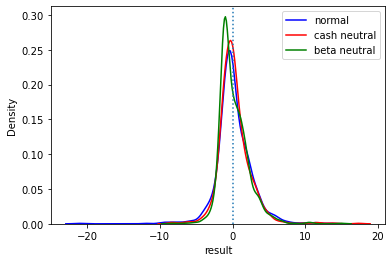

In [47]:
sns.kdeplot(x=closed.result, color='blue', label='normal')
sns.kdeplot(x=closed.result_cash_neutral, color='red', label='cash neutral')
sns.kdeplot(x=closed.result_beta_neutral, color='green', label='beta neutral')

plt.axvline(x=0, linestyle='dotted')
plt.legend()
plt.show()

In [63]:
print(closed.loc[closed.is_profit].result.mean())
print(closed.loc[closed.is_profit_CN].result_cash_neutral.mean())
print(closed.loc[closed.is_profit_BN].result_beta_neutral.mean())

print(closed.loc[~closed.is_profit].result.mean())
print(closed.loc[~closed.is_profit_CN].result_cash_neutral.mean())
print(closed.loc[~closed.is_profit_BN].result_beta_neutral.mean())

1.9448316831683166
1.7239443839758601
1.7888087514333206
-1.3583247863247865
-1.200501826488127
-1.1741656711714106


In [48]:
closed.loc[closed.result_cash_neutral.idxmax()]

date                      2020-03-27 00:00:00
pair                       ('AMER3', 'MGLU3')
status                                  close
price_fst_stock                         49.99
price_scnd_stock                         9.72
beta_open                            4.181987
beta_close                           4.339482
last_residual                        0.702329
std_residual                         4.326128
std_open_residual                     4.78419
residual_open                       10.906997
open_price_first_stock                  49.72
open_price_scnd_stock                    7.18
open_date                 2020-03-18 00:00:00
close_limit                          2.392095
stop_limit                          10.568379
data_ini                  2019-07-01 00:00:00
data_fin                  2019-12-31 00:00:00
setor                                  Varejo
result                                   2.27
quant1                                    1.0
quant2                            

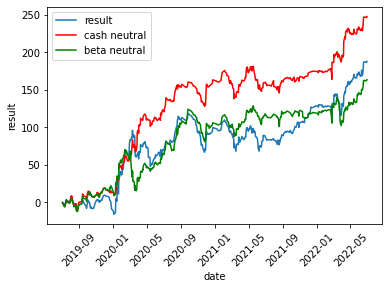

In [49]:
sns.lineplot(x=closed_daily.index, y=closed_daily.result.cumsum(), label='result')
sns.lineplot(x=closed_daily.index, y=closed_daily.result_cash_neutral.cumsum(),color='red', label='cash neutral')
sns.lineplot(x=closed_daily.index, y=closed_daily.result_beta_neutral.cumsum(),color='green', label='beta neutral')


plt.xticks(rotation=45)
plt.show()

In [50]:
closed_by_sector = closed.groupby('setor').agg(
    result = ('result', 'sum'),
    result_mean = ('result', 'mean'),
    result_CN = ('result_cash_neutral', 'sum'),
    result_mean_CN = ('result_cash_neutral', 'mean'),
    count = ('result', 'count'),
    accuracy = ('is_profit', 'mean'),
    accuracy_CN = ('is_profit_CN', 'mean')
)

closed_by_sector.sort_values(by='accuracy', ascending=False)

,result,result_mean,result_CN,result_mean_CN,count,accuracy,accuracy_CN
setor,,,,,,,
Saúde,90.28,0.868077,73.057576,0.702477,104,0.596154,0.567308
Bens Industriais,14.48,0.273208,24.198130,0.456568,53,0.584906,0.547170
Papel e Celulose,9.09,1.298571,10.460175,1.494311,7,0.571429,0.857143
Mineração e Siderurgia,2.82,0.042727,11.761460,0.178204,66,0.500000,0.606061
"Petroleo, gás e biocombustíveis",-17.78,-0.250423,-22.060057,-0.310705,71,0.492958,0.492958
Utilidade Pública,-56.94,-0.206304,22.242826,0.080590,276,0.456522,0.471014
Financeiro,121.78,0.361365,96.712353,0.286980,337,0.445104,0.471810
Construção Civil,0.36,0.051429,-5.695238,-0.813605,7,0.428571,0.428571
Alimentos e Bebidas,4.60,0.124324,5.310019,0.143514,37,0.405405,0.540541


In [51]:
closed_by_sector = closed.groupby('setor').agg(
    result = ('result', 'sum'),
    result_mean = ('result', 'mean'),
    result_CN = ('result_cash_neutral', 'sum'),
    result_mean_CN = ('result_cash_neutral', 'mean'),
    count = ('result', 'count'),
    accuracy = ('is_profit', 'mean'),
    accuracy_CN = ('is_profit_CN', 'mean')
)

closed_by_sector.sort_values(by='accuracy', ascending=False)

,result,result_mean,result_CN,result_mean_CN,count,accuracy,accuracy_CN
setor,,,,,,,
Saúde,90.28,0.868077,73.057576,0.702477,104,0.596154,0.567308
Bens Industriais,14.48,0.273208,24.198130,0.456568,53,0.584906,0.547170
Papel e Celulose,9.09,1.298571,10.460175,1.494311,7,0.571429,0.857143
Mineração e Siderurgia,2.82,0.042727,11.761460,0.178204,66,0.500000,0.606061
"Petroleo, gás e biocombustíveis",-17.78,-0.250423,-22.060057,-0.310705,71,0.492958,0.492958
Utilidade Pública,-56.94,-0.206304,22.242826,0.080590,276,0.456522,0.471014
Financeiro,121.78,0.361365,96.712353,0.286980,337,0.445104,0.471810
Construção Civil,0.36,0.051429,-5.695238,-0.813605,7,0.428571,0.428571
Alimentos e Bebidas,4.60,0.124324,5.310019,0.143514,37,0.405405,0.540541


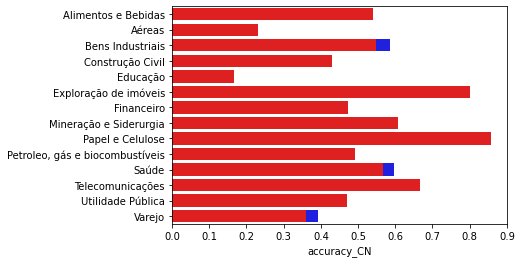

In [52]:
sns.barplot(y=closed_by_sector.index, x=closed_by_sector.accuracy, orient='h', color='blue')
sns.barplot(y=closed_by_sector.index, x=closed_by_sector.accuracy_CN, orient='h', color='red')

plt.ylabel(None)
plt.show()

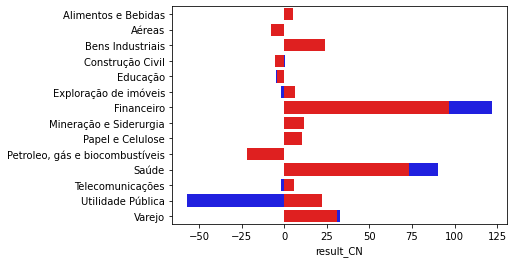

In [53]:
sns.barplot(y=closed_by_sector.index, x=closed_by_sector.result, orient='h', color='blue')
sns.barplot(y=closed_by_sector.index, x=closed_by_sector.result_CN, orient='h', color='red')

plt.ylabel(None)
plt.show()

In [54]:
pair_closed = closed.groupby('pair').agg(
    result_sum=('result', 'sum'),
    result_mean=('result', 'mean'),
    result_sum_CN=('result_cash_neutral', 'sum'),
    result_mean_CN=('result_cash_neutral', 'mean'),
    count=('result', 'count'),
    accuracy=('is_profit', 'mean'),
    accuracy_CN=('is_profit_CN', 'mean'),
    sector=('setor', 'last')
    )

pair_closed.sort_values(by=['accuracy_CN', 'count'], ascending=False).head(25)

,result_sum,result_mean,result_sum_CN,result_mean_CN,count,accuracy,accuracy_CN,sector
pair,,,,,,,,
"('TAEE11', 'EQTL3')",9.95,1.243750,13.081877,1.635235,8,0.875000,1.0,Utilidade Pública
"('PETR4', 'PETR3')",2.07,0.345000,2.187647,0.364608,6,0.833333,1.0,"Petroleo, gás e biocombustíveis"
"('GGBR4', 'GOAU4')",1.49,0.298000,1.405627,0.281125,5,0.800000,1.0,Mineração e Siderurgia
"('GOAU4', 'GGBR4')",3.18,0.636000,0.773223,0.154645,5,0.800000,1.0,Mineração e Siderurgia
"('QUAL3', 'FLRY3')",12.61,2.522000,13.034548,2.606910,5,1.000000,1.0,Saúde
"('ENBR3', 'CPLE6')",-1.42,-0.355000,3.125395,0.781349,4,0.500000,1.0,Utilidade Pública
"('LREN3', 'VIIA3')",8.19,2.047500,9.325164,2.331291,4,0.750000,1.0,Varejo
"('ABEV3', 'JBSS3')",3.74,1.246667,2.392263,0.797421,3,0.666667,1.0,Alimentos e Bebidas
"('BBDC3', 'IRBR3')",0.48,0.160000,2.450781,0.816927,3,0.333333,1.0,Financeiro


In [55]:
pair_closed.to_excel('pares_parcial.xlsx')

In [56]:
bd = pd.read_excel("BD COMPLETO.xlsx")
bd.dropna(inplace=True)
bd.set_index('Data', inplace=True)

In [240]:
bd['log_ret'] = np.log(bd['BOVA11']/ bd['BOVA11'].shift())
bd

,ARZZ3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BEEF3,BOVA11,BRAP4,...,TAEE11,TIET11,VVAR3,YDUQ3,NTCO3,ITSA4,BPAC11,BOVV11,dol,log_ret
Data,,,,,,,,,,,,,,,,,,,,,
2017-04-11,28.5749,22.40,17.4028,28.1720,17.3703,17.6168,21.0011,9.78,62.42,17.2488,...,16.4007,10.4669,3.9803,14.2525,14.7845,6.8240,15.8492,64.46,3.531422,NaN
2017-04-12,28.5031,22.96,17.3301,27.7085,17.2553,17.4412,20.7890,9.87,61.68,16.2195,...,16.5075,10.3283,4.2291,14.5797,14.7213,6.7885,16.1625,64.00,3.519090,-0.011926
2017-04-13,28.7992,22.99,16.8300,26.2664,16.7844,16.9090,20.5403,9.95,60.80,16.3053,...,16.2939,10.3822,4.2291,13.9166,14.5948,6.6179,15.5868,62.93,3.536467,-0.014370
2017-04-17,28.6646,22.85,17.7756,27.4853,17.4415,17.6662,21.2791,10.00,62.25,16.5540,...,16.3865,10.4515,4.1793,14.7654,15.0277,6.7956,15.5783,64.44,3.483776,0.023569
2017-04-18,28.2609,23.91,17.9120,27.7514,17.4470,17.5619,21.2060,9.95,61.95,16.1166,...,16.5929,10.3052,4.3684,14.6769,14.9061,6.8525,15.2397,64.20,3.492744,-0.004831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-10,56.9600,26.10,56.0000,32.4254,19.3100,20.8500,26.2800,12.93,95.04,43.0300,...,28.7300,14.9000,18.0200,27.3100,49.7500,9.4600,79.1300,99.20,5.325000,-0.025555
2020-09-11,55.7500,26.58,56.0200,31.8971,18.8700,20.4600,25.4700,12.93,94.48,44.9000,...,28.3800,14.6500,17.9600,27.8900,51.6200,9.2700,78.1100,98.60,5.320500,-0.005910
2020-09-14,57.1700,28.25,58.7300,32.3600,19.1600,20.7000,25.8600,13.27,96.51,44.5500,...,28.6000,14.7700,18.3700,30.1100,53.2600,9.3800,81.4800,100.72,5.273000,0.021258


In [241]:
gpd = df.loc[df.status=='close'].groupby('date').sum().cumsum()
gpd.index = pd.to_datetime(gpd.index)

In [242]:
log_ret = bd.log_ret.rolling(103).std() * math.sqrt(252) * 100
bd['log_ret'] = log_ret
dd = gpd.join(bd, how='left')

In [243]:
dd.tail()

,Unnamed: 0,price_fst_stock,price_scnd_stock,beta,last_residual,std_residual,std_open_residual,residual_open,open_price_first_stock,open_price_scnd_stock,...,TAEE11,TIET11,VVAR3,YDUQ3,NTCO3,ITSA4,BPAC11,BOVV11,dol,log_ret
date,,,,,,,,,,,,,,,,,,,,,
2020-09-09,2023459,153315.2398,133838.780443,4598.712571,2438.870269,6027.001567,5508.004742,1587.831755,152065.9483,132933.602791,...,29.24,15.00,18.51,27.99,50.72,9.68,81.51,101.84,5.3125,27.819332
2020-09-10,2027911,153530.0298,134065.620443,4605.470703,2458.813394,6034.175484,5514.794709,1602.400746,152279.9083,133165.022891,...,28.73,14.90,18.02,27.31,49.75,9.46,79.13,99.20,5.3250,28.121526
2020-09-11,2033112,153700.4498,134203.500443,4609.935487,2463.226779,6040.043439,5520.014270,1607.310900,152451.1851,133304.013891,...,28.38,14.65,17.96,27.89,51.62,9.27,78.11,98.60,5.3205,28.080393
2020-09-14,2040552,154000.0398,134422.380443,4624.645357,2465.772731,6053.392315,5532.372547,1607.244930,152748.8051,133528.386891,...,28.60,14.77,18.37,30.11,53.26,9.38,81.48,100.72,5.2730,28.109877
2020-09-15,2045767,154226.1198,134554.700443,4643.035102,2468.318826,6064.113085,5542.253587,1601.723373,152973.6151,133665.316891,...,28.56,14.76,18.55,29.70,53.50,9.26,79.89,100.64,5.2780,28.052406


In [244]:
dd[['result', 'log_ret']].corr()

,result,log_ret
result,1.000000,0.723979
log_ret,0.723979,1.000000


In [245]:
px.line(dd[['result', 'log_ret']])

In [203]:
px.line(x=result_sum.index, y=result_sum.profit_loss)


In [79]:
bd.log_ret['2019'].std() * math.sqrt(252)

0.18208665089545323

In [193]:
(bd['BOVA11'] / bd['BOVA11'].shift()).std() * math.sqrt(252)

0.2925416460702591

In [179]:
bd['BOVA11'].pct_change()

Data
2017-04-11         NaN
2017-04-12   -0.011855
2017-04-13   -0.014267
2017-04-17    0.023849
2017-04-18   -0.004819
                ...   
2020-09-10   -0.025231
2020-09-11   -0.005892
2020-09-14    0.021486
2020-09-15   -0.000518
2020-09-16   -0.005702
Name: BOVA11, Length: 849, dtype: float64

In [72]:
# Volatility
bd['log_ret'] = np.log(bd['BOVA11']/ bd['BOVA11'].shift())
anualized_vol = bd.log_ret.rolling(103).std() * math.sqrt(252) * 100


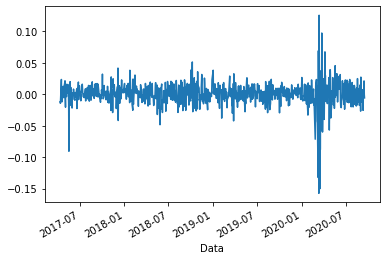

In [73]:
bd.log_ret.plot()

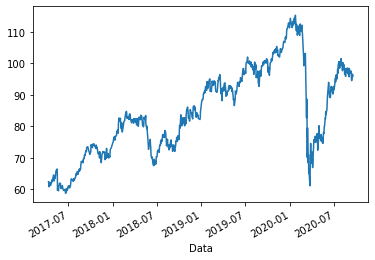

In [74]:
bd['BOVA11'].plot()

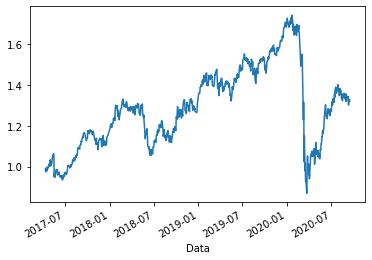

In [76]:
np.cumprod(1+bd['log_ret']).plot()